In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

<IPython.core.display.Javascript object>


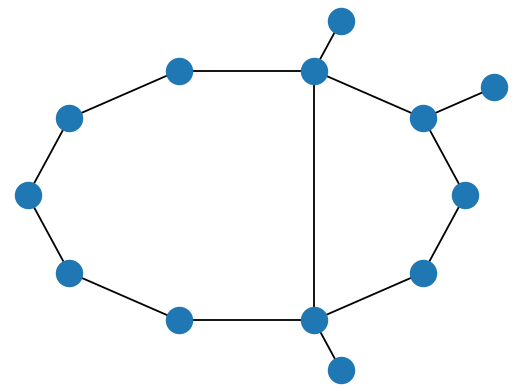

In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

Total lenght: 8.082452920089256
Average lenght: 0.7347684472808415


In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

<IPython.core.display.Javascript object>


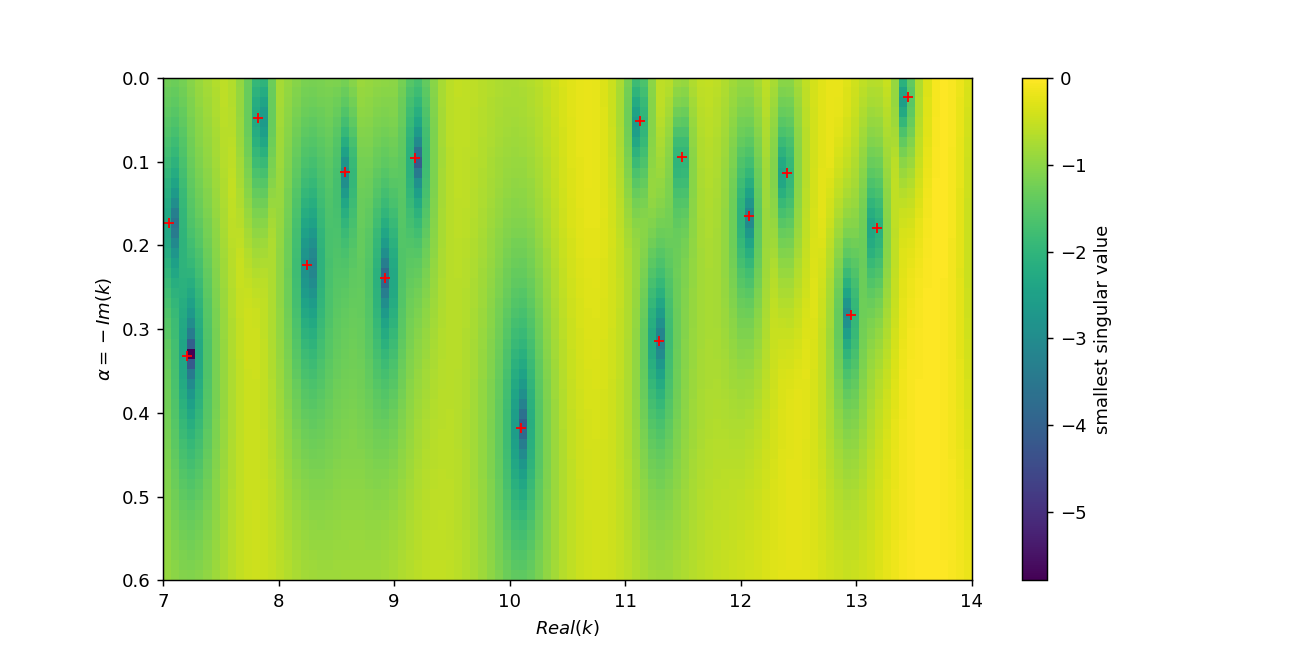

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


In [6]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 1.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [0, 1, 2, 3, 4, 5, 10]  #edges to pump

m = 0
naq_u1.update_chi(modes[m])
print("condition number no pump:", naq_u1.test_laplacian())

naq_u1.pump_params['D0']         = 1e-2
naq_u1.update_chi(modes[m])
print("condition number with pump:", naq_u1.test_laplacian())


condition number no pump: 0.0004521141
condition number with pump: 0.20017844


In [7]:
#find the pump trajectories
params['s_size']    = 1e-2*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .1
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


<IPython.core.display.Javascript object>


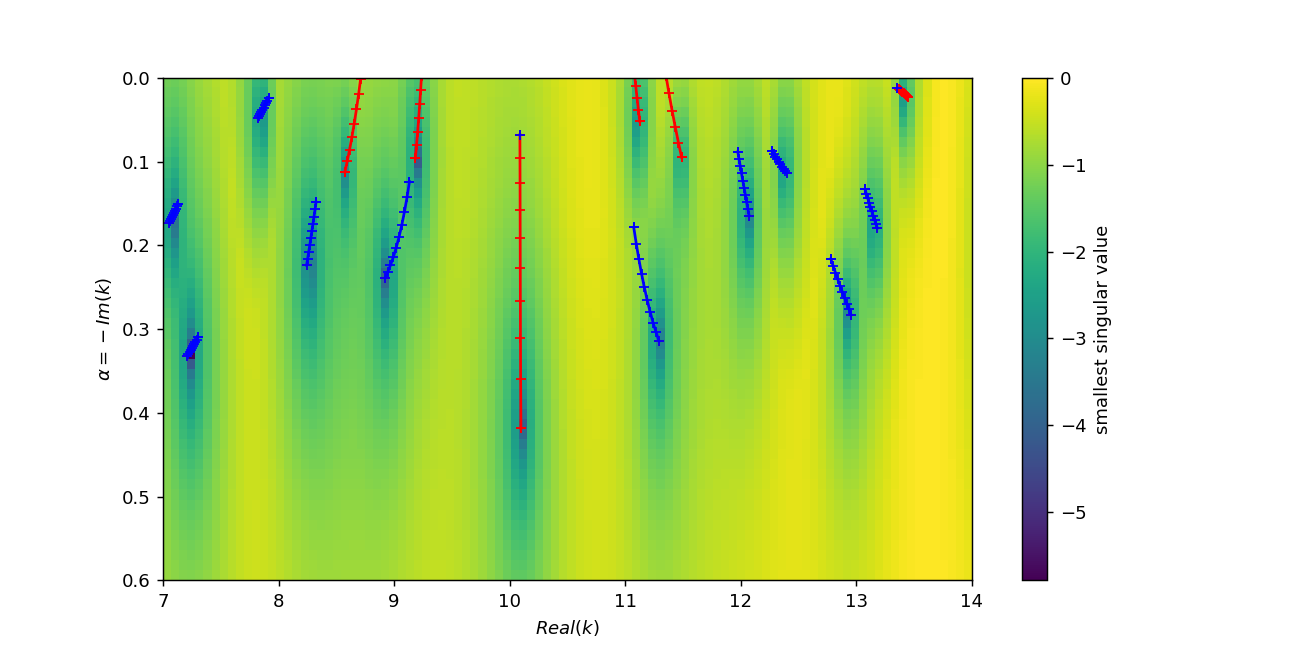

In [8]:
#plot the pump trajectories
naq_u1.plot_pump_traj(Ks, Alphas, s, modes, new_modes)

In [9]:
params['s_size']    = 5e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 16/16 [00:34<00:00,  5.31s/it]


<IPython.core.display.Javascript object>


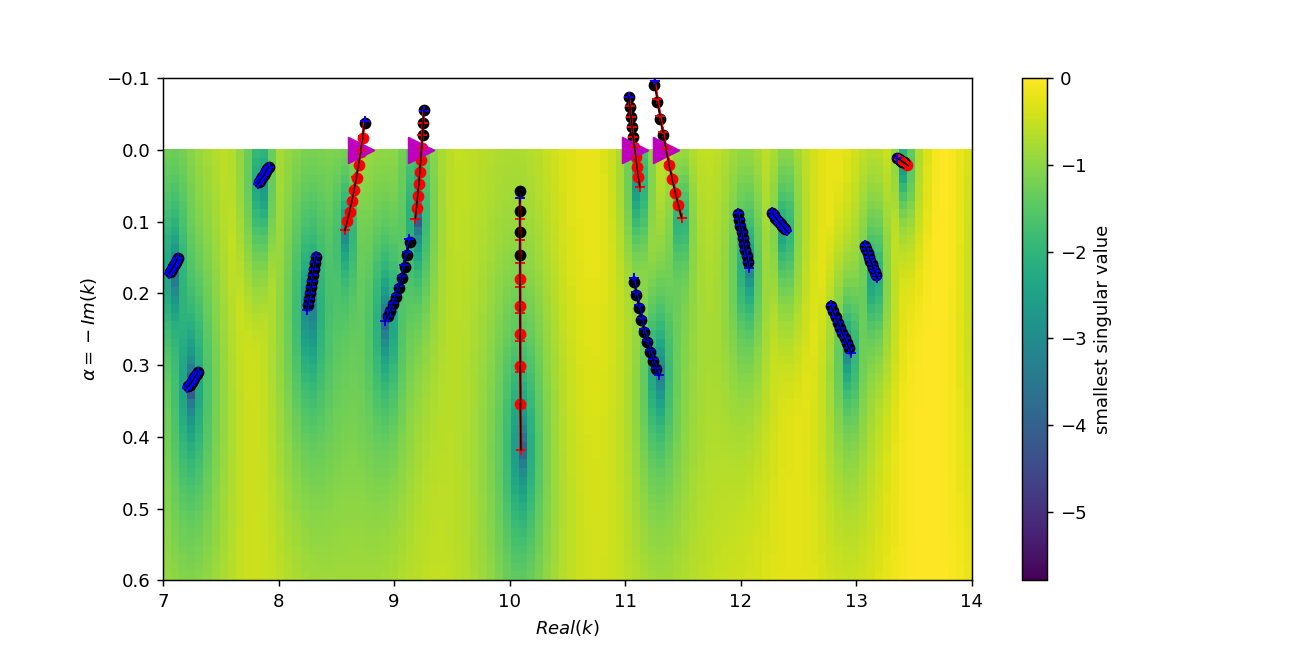

In [60]:
#plot the trajectories and the lasing modes

naq_u1.plot_pump_traj(  Ks, Alphas, s, modes, new_modes, estimate=True)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.1])

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
#plt.axis([13.3, 13.5, 0.03, -0.01])
plt.show()

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later

In [63]:
D0 = 0.06
th_modes_selec = []
D0_th_selec = []
for i, m in enumerate(th_modes):
    if type(m) == np.ndarray:
        th_modes_selec.append(m)
        D0_th_selec.append(D0_th[i])
        
th_modes_selec = np.asarray(th_modes_selec)
D0_th_selec = np.asarray(D0_th_selec)
print(th_modes_selec)
print(D0_th_selec)

[[ 1.10842118e+01  4.27736378e-05]
 [ 1.13566387e+01 -9.98151655e-05]
 [ 9.23604257e+00  6.95071221e-05]
 [ 8.71101538e+00  3.89037447e-05]]
[0.04115545 0.05414051 0.06469152 0.0781204 ]


k= (11.084211786719278-4.277363783019686e-05j)


<IPython.core.display.Javascript object>


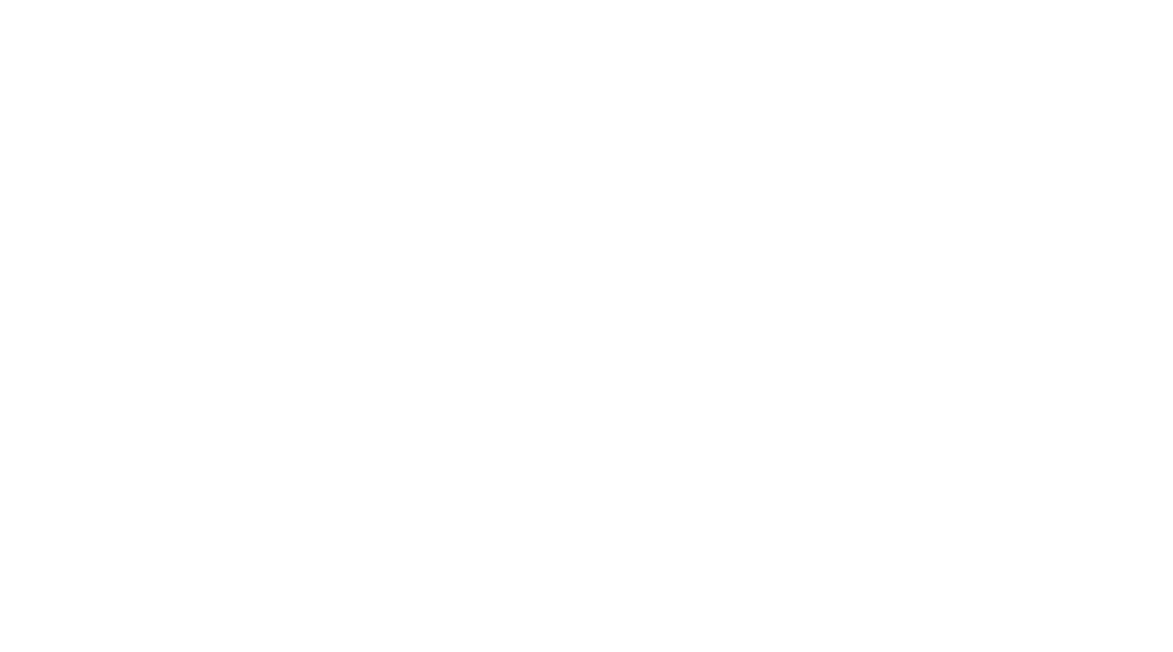

k= (11.356638683675394+9.981516545126901e-05j)


<IPython.core.display.Javascript object>


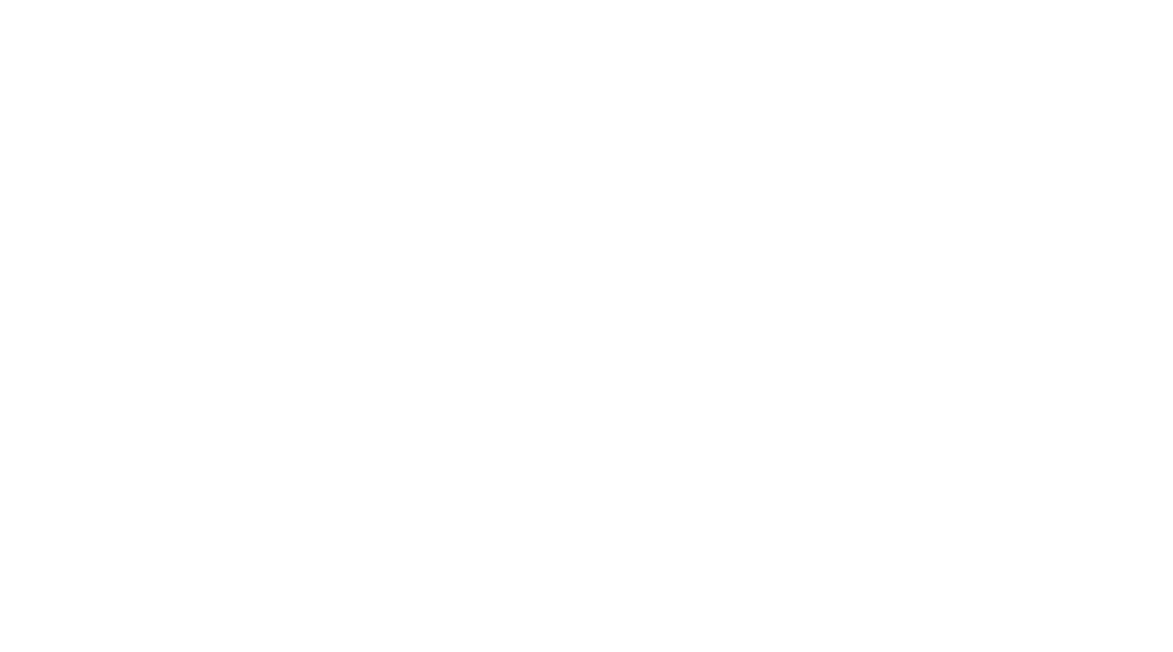

k= (9.236042566475621-6.950712214041665e-05j)


<IPython.core.display.Javascript object>


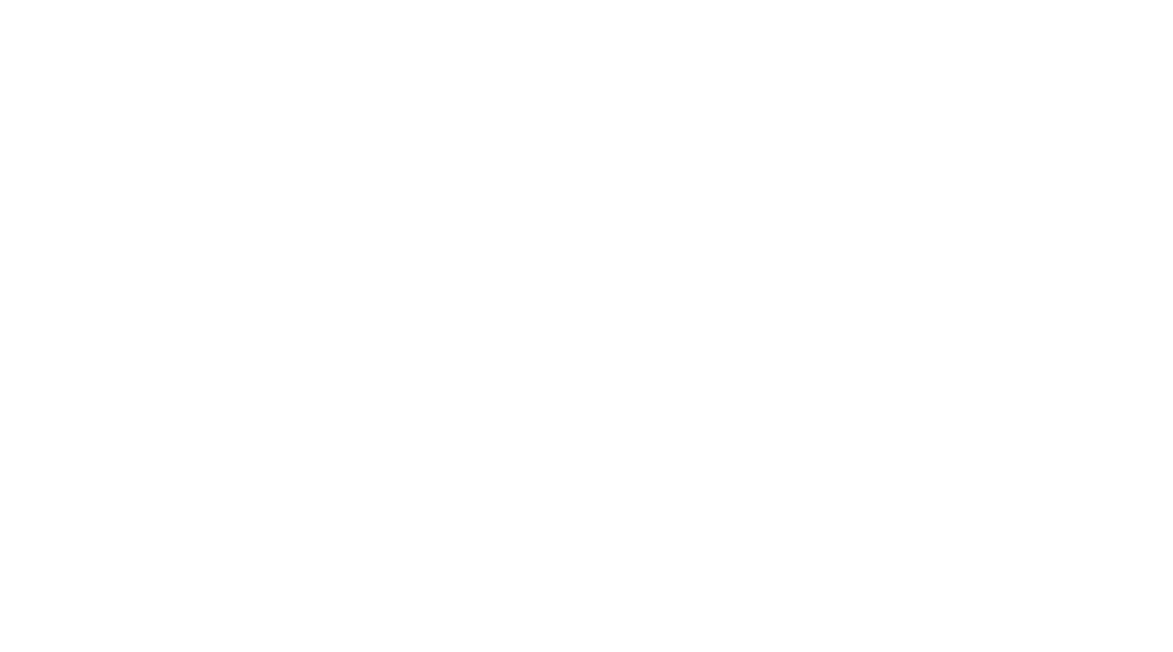

k= (8.71101538167579-3.8903744683008295e-05j)


<IPython.core.display.Javascript object>


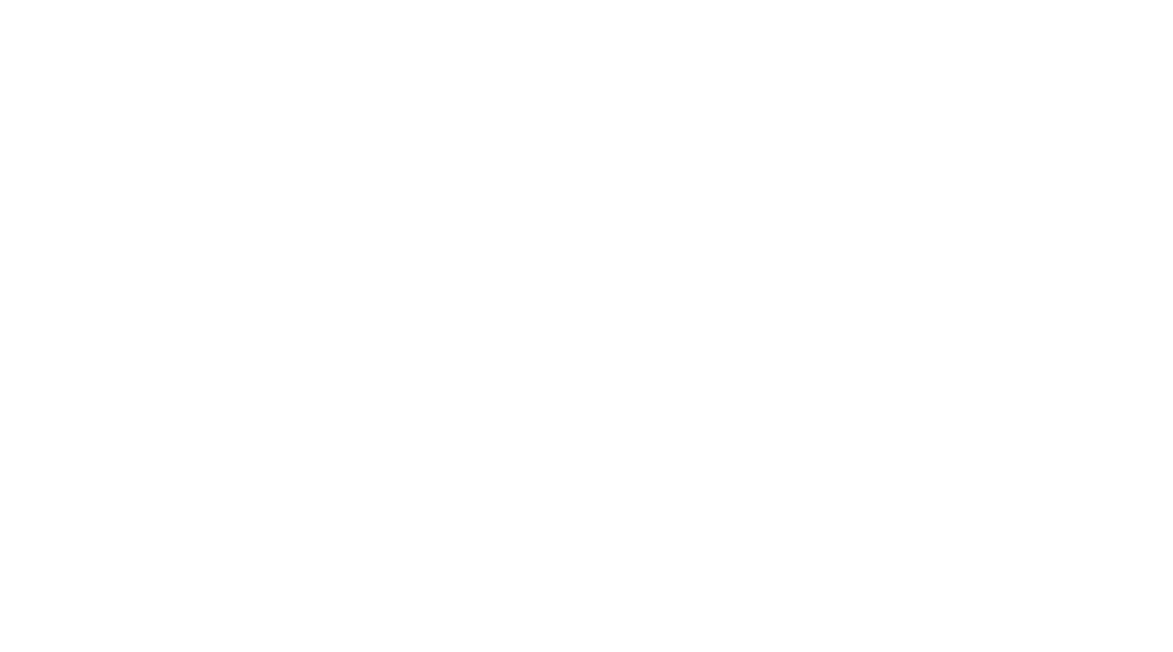

In [69]:

#for each mode, save a figure for it
if not os.path.isdir('lasing_modes'):
    os.mkdir('lasing_modes')

for m in range(len(th_modes_selec)):
    print("k=", th_modes_selec[m,0]-1j*th_modes_selec[m,1])
    
    naq_u1.pump_params['D0'] = D0_th_selec[m]

    naq_u1.update_chi((th_modes_selec[m,0]-1j*th_modes_selec[m,1]))

    naq_u1.update_laplacian()
    phi = naq_u1.compute_solution()
    edge_color = naq_u1.compute_edge_mean_E2()

    plt.figure(figsize=(9,5))
    nodes = nx.draw_networkx_nodes(G,pos=pos, node_color = 'k', node_size=50)# np.abs(phi)**2, cmap='plasma')
    edges_k = nx.draw_networkx_edges(G,pos=pos, edge_color = 'k', width=2)
    edges = nx.draw_networkx_edges(G,pos=pos, edge_color = edge_color, edge_cmap=plt.get_cmap('Greens'), width=8, alpha=0.7, edge_vmin=0)
    
    #plt.colorbar(nodes, label=r'Node $|E_i|^2$')
    plt.colorbar(edges, label=r'Edges $\frac{1}{l_{ij}}\int_0^{l_{ij}}|E_{ij}(x)|^2 dx$')

    plt.title("k="+str(np.around(th_modes_selec[m,0],2)-1j*np.around(th_modes_selec[m,1],3)))
    plt.axis('off')
    plt.savefig('lasing_modes/lasing_mode_'+str(m)+'.svg')
    plt.close()

In [127]:
def T_matrix(self, th_modes, D0_th):
            """
            Compute the T_{\mu\nu} matrix for nonlinear SALT
            """

            #first extract the flux vectors and Gammas
            fluxes = []
            gammas = []
            n_modes = len(D0_th) #number of modes
            for i in range(n_modes):
                
                self.pump_params['D0'] = D0_th[i]
                
                self.update_chi(th_modes[i])
                self.update_laplacian()
                phi = self.compute_solution()
                
                #compute the flux normalisation
                self.Z_matrix_U1() #compute the Z matrix
                edge_norm = self.Winv.dot(self.Z).dot(self.Winv) #compute the correct weight matrix
                L0_in = self.BT.dot(edge_norm.dot(self.pump_mask)).dot(self.B).asformat('csc')
                L0_in_norm = phi.T.dot(L0_in.dot(phi))
            
                #compute the edge solution
                flux = self.Winv.dot(self.BT.T).dot(phi) / np.sqrt(L0_in_norm) 
                
                fluxes.append(flux)
                gammas.append(self.gamma)
                
            #populate the matrix, entry by entry (not a symmetric matrix!)
            T = np.zeros([n_modes, n_modes], dtype=np.complex64)
            for mu in range(n_modes):
                for nu in range(n_modes):
                    
                    #first set shorthand notations (following the notes)
                    lamb_mu = fluxes[mu]
                    lamb_nu = fluxes[nu]
                    
                    k_mu = (th_modes[mu][0]-1.j*th_modes[mu][1])*np.sqrt(1. + gammas[mu] * D0_th[mu])
                    k_nu = (th_modes[nu][0]-1.j*th_modes[nu][1])*np.sqrt(1. + gammas[nu] * D0_th[nu]) 
                    
                    Delta = k_nu - np.conj(k_nu)
                    Lamb  = k_nu + np.conj(k_nu)
                    
                    #compute the matrix element looping only on the pumped edges
                    for ei, e in enumerate(list(self.graph.edges())):
                        if ei in self.pump_params['edges']:
                            (u, v) = e[:2]

                            #shortand notation (as in the notes)
                            lamb_nu_plus = lamb_nu[2*ei]
                            lamb_nu_minus = lamb_nu[2*ei+1]
                            lamb_mu_plus = lamb_mu[2*ei]
                            lamb_mu_minus = lamb_mu[2*ei+1]
                            l = self.graph[u][v]['L']
                            
                            exp_term_1 = ( np.exp(1.j*(2*k_mu+Delta)*l) - 1. ) / (1.j*(2*k_mu+Delta))

                            T[mu, nu] += exp_term_1 * ( abs(lamb_nu_plus)**2*lamb_mu_plus**2  + 
                                                        abs(lamb_nu_minus)**2*lamb_mu_minus**2
                                                       )
                            
                            exp_term_2 = ( np.exp(2.j*k_mu*l) 
                                          - np.exp(Delta*l) ) / (1.j*(2*k_mu-Delta))

                            T[mu, nu] += exp_term_2 * ( abs(lamb_nu_plus)**2*lamb_mu_minus**2 +
                                                        abs(lamb_nu_minus)**2*lamb_mu_plus**2 
                                                       )
                            
                            exp_term_3 = np.exp(1.j*k_mu*l)*(np.exp(1.j*Delta*l) - 1.) / (1.j*Delta) 
                            
                            T[mu, nu] += 2*exp_term_3 * ( abs(lamb_nu_plus)**2*lamb_mu_plus*lamb_mu_minus +
                                                          abs(lamb_nu_minus)**2*lamb_mu_plus*lamb_mu_minus
                                                        )
                            
                            exp_term_4 = ( np.exp(1.j*(2.*k_mu+k_nu)*l) 
                                          - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*(2*k_nu+Lamb))
                            
                            T[mu, nu] += exp_term_4 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_plus**2 +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus**2
                                                      )
                            
                            exp_term_5 = ( np.exp(1.j*(2.*k_mu-np.conj(k_nu))*l) 
                                          - np.exp(1.j*k_nu*l) ) / (1.j*(2*k_nu-Lamb))
                            
                            T[mu, nu] += exp_term_5 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus**2 +
                                                       np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_plus**2
                                                      )
                        
                            exp_term_6 =   np.exp(1.j*k_mu*l) * ( np.exp(1.j*k_nu*l) 
                                                - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*Lamb)
                                
                            T[mu, nu] += 2*exp_term_6 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus*lamb_mu_plus +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus*lamb_mu_plus
                                                      )
                            
                    T[mu, nu] *= np.imag(-gammas[nu]) #finally multiply by \Gamma_\nu and use only the real part of T
            print(np.abs(T))
            #T = 0*T+.3#/len(T)
            #T += np.diag((1-.3)*np.ones(len(T)))
            
            return (np.real(T)) #convert it to a array with real numbers
                                
T = T_matrix(naq_u1, th_modes_selec, D0_th_selec)
print(T)


[[0.25075352 0.08762586 0.26461256 0.09721389]
 [0.16493732 0.16958605 0.09597728 0.08007029]
 [0.26059842 0.04303455 0.36545816 0.13041604]
 [0.12944162 0.12202737 0.1749045  0.16446961]]
[[ 0.24814452  0.05355441  0.2546604  -0.01470678]
 [ 0.1388786   0.1695687   0.09168793  0.05435492]
 [ 0.2506674  -0.00312178  0.34898984  0.09053462]
 [ 0.12282452  0.04075636  0.12149543  0.1638052 ]]


In [128]:
def modal_intensities(self, D0_max, D0_steps, th_modes, D0_th):
    """
    compute the modal intensities of the modes up to D0, with D0_steps
    """
    D0_th = np.array(D0_th)
    th_modes = np.array(th_modes)
    
    n_modes = len(D0_th)
    
    D0s = np.linspace(0, D0_max, D0_steps)
    
    D0_th_min = np.min(D0_th) #smallest lasing threshold
    th_mode_first = th_modes[np.argmin(D0_th)] #first lasing mode
    
    D0_th_inv = 1./D0_th #inverse of lasing thresholds
    
    I = np.zeros([n_modes, D0_steps]) #collect the modal intensities
    lasing_modes = [] #ordered list of lasing modes ids
    
    next_D0 = D0_th_min #set the next lasing threshold to the minimum one 
    next_lasing_mode  = np.argmin(D0_th) #set the next lasing mode as the first to possibly lase
      
    for i, D0 in enumerate(D0s):
        print('D0', D0, 'next', next_D0)
        if D0 > D0_th_min: #before the first mode lases, nothing happens
            
            #while we can add new lasing modes, add them 
            search_new_lasing_modes = True 
            while search_new_lasing_modes:

                if D0 > next_D0: #if the next mode can be lased, add it and search the next one
                    lasing_modes += [next_lasing_mode,]
                    print('lasing modes', lasing_modes)


                    #if needed, compute all the interacting thresholds for the non-lasing modes
                    D0_ints = np.ones(n_modes)*1e5 #to collect the interacting thresholds, set them to large for later search of smallest
                    for mu in range(n_modes):
                        if mu not in lasing_modes:

                            #first compute the larger T matrix (including the mode m)
                            T_mu = T_matrix(self, th_modes[lasing_modes + [mu,]], D0_th_selec[lasing_modes + [mu,]])
                            T_mu_inv = np.linalg.inv(T_mu)

                            #compute the interacting threshold of mode m
                            D0_ints[mu] = 1./ ( T_mu_inv[-1].dot(D0_th_inv[lasing_modes + [mu,]]) / T_mu_inv[-1].dot( np.ones(len(lasing_modes)+1)) )
                            
                    #print(D0_ints, D0)
                    #next interacting threshold
                    next_D0 = np.min(abs(D0_ints) )
                    next_lasing_mode = np.argmin(D0_ints)

                else: #if the next mode does not lase, stop the search and compute the modal intensities
                    search_new_lasing_modes = False
                    
            #update the T^{-1} matrix with new the new mode
            T_inv = np.linalg.pinv(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))
            #print(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))
            #print(T_inv)
            #compute the modal intensities
            I[lasing_modes, i] = D0*T_inv.dot(D0_th_inv[lasing_modes]) - T_inv.sum(1)
            #print(T_inv.dot(D0_th_inv[lasing_modes]),T_inv )
    return I

D0_steps = 100
D0_max = 0.5

I = modal_intensities(naq_u1, D0_max, D0_steps, th_modes_selec, D0_th_selec)

D0 0.0 next 0.04115545157848163
D0 0.005050505050505051 next 0.04115545157848163
D0 0.010101010101010102 next 0.04115545157848163
D0 0.015151515151515152 next 0.04115545157848163
D0 0.020202020202020204 next 0.04115545157848163
D0 0.025252525252525256 next 0.04115545157848163
D0 0.030303030303030304 next 0.04115545157848163
D0 0.03535353535353536 next 0.04115545157848163
D0 0.04040404040404041 next 0.04115545157848163
D0 0.045454545454545456 next 0.04115545157848163
lasing modes [0]
[[0.25075352 0.08762586]
 [0.16493732 0.16958605]]
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
[[0.25075352 0.09721389]
 [0.12944162 0.16446961]]
lasing modes [0, 2]
[[0.25075352 0.26461256 0.08762586]
 [0.26059842 0.36545816 0.04303455]
 [0.16493732 0.09597728 0.16958605]]
[[0.25075352 0.26461256 0.09721389]
 [0.26059842 0.36545816 0.13041604]
 [0.12944162 0.1749045  0.16446961]]
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.05050505050505051 next 1.5631643355751608
[[0.25075352 0.26461256

[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.4545454545454546 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.4595959595959596 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.4646464646464647 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.4696969696969697 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.4747474747474748 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.47979797979797983 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.48484848484848486 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.48989898989898994 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.494949494949495 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.36545816]]
D0 0.5 next 1.5631643355751608
[[0.25075352 0.26461256]
 [0.26059842 0.365

<IPython.core.display.Javascript object>


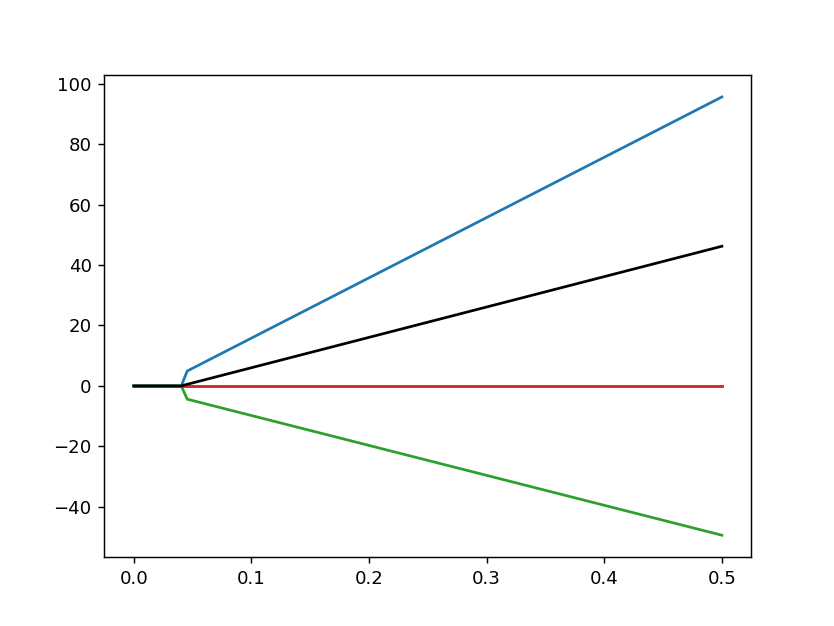

In [129]:
plt.figure()
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    plt.plot(D0s, (I[i]), '-')
    
plt.plot(D0s,I.sum(0),'-k')